In [291]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
from datetime import datetime
from datetime import date
from scipy.stats import linregress
import matplotlib.ticker as ticker

from config import g_key


In [292]:
#define and read data files
flu_file = "input_data/flu_data.csv"
flight_file = "input_data/Flights_3_12_2020.csv"
lat_lng_csv = "input_data/citycoords.csv"

#read CSV input files
flu_data = pd.read_csv(flu_file, encoding = 'ISO-8859-1')
flight_data_df = pd.read_csv(flight_file, encoding = 'ISO-8859-1')
lat_lng_df = pd.read_csv(lat_lng_csv)

#convert time values from flu data
flu_data['SDATE'] = pd.to_datetime(flu_data["SDATE"])
flu_data['EDATE'] = pd.to_datetime(flu_data["EDATE"])

#rename columns in lat long file
lat_lng_df = lat_lng_df.rename(columns={"name_long": "Country"})

#rename columns in flu data
flu_data = flu_data.rename(columns = {'AH1N12009':'H1N1_Cases'})
                

#shorten time-frame in flu data
trimmed_flu_data = flu_data.loc[(flu_data["EDATE"] >= "2009-05-01") & (flu_data["EDATE"] < "2010-04-01") ]

#remove unecessary columns  in flu data
trimmed_flu_data = trimmed_flu_data[['WHOREGION', 'Country', 'Year', 'Month', 'Week', 'SDATE', 'EDATE', 'H1N1_Cases', 'TITLE' ]]

#preview data
trimmed_flu_data.head()


,WHOREGION,Country,Year,Month,Week,SDATE,EDATE,H1N1_Cases,TITLE
17,Region of the Americas of WHO,Anguilla,2009,5,18,2009-04-27,2009-05-03,NaN,No Report
18,Region of the Americas of WHO,Anguilla,2009,5,19,2009-05-04,2009-05-10,NaN,No Report
19,Region of the Americas of WHO,Anguilla,2009,5,20,2009-05-11,2009-05-17,NaN,No Report
20,Region of the Americas of WHO,Anguilla,2009,5,21,2009-05-18,2009-05-24,NaN,No Report
21,Region of the Americas of WHO,Anguilla,2009,5,22,2009-05-25,2009-05-31,NaN,No Report


In [293]:
# replace NaN values with 0's
trimmed_flu_data = trimmed_flu_data.fillna(0)

trimmed_flu_data

# #group data by region
# who_region= flu_data.groupby('WHOREGION').sum()

# who_region = who_region.reset_index()
# who_region = who_region[['WHOREGION', 'H1N1_Cases']]

# who_region.sort_values(by = ['H1N1_Cases'], inplace = True, ascending = False, axis = 0)

# who_region

,WHOREGION,Country,Year,Month,Week,SDATE,EDATE,H1N1_Cases,TITLE
17,Region of the Americas of WHO,Anguilla,2009,5,18,2009-04-27,2009-05-03,0.0,No Report
18,Region of the Americas of WHO,Anguilla,2009,5,19,2009-05-04,2009-05-10,0.0,No Report
19,Region of the Americas of WHO,Anguilla,2009,5,20,2009-05-11,2009-05-17,0.0,No Report
20,Region of the Americas of WHO,Anguilla,2009,5,21,2009-05-18,2009-05-24,0.0,No Report
21,Region of the Americas of WHO,Anguilla,2009,5,22,2009-05-25,2009-05-31,0.0,No Report
...,...,...,...,...,...,...,...,...,...
17910,Western Pacific Region of WHO,Viet Nam,2010,2,8,2010-02-22,2010-02-28,7.0,No Report
17911,Western Pacific Region of WHO,Viet Nam,2010,3,9,2010-03-01,2010-03-07,3.0,No Report
17912,Western Pacific Region of WHO,Viet Nam,2010,3,10,2010-03-08,2010-03-14,2.0,No Report
17913,Western Pacific Region of WHO,Viet Nam,2010,3,11,2010-03-15,2010-03-21,2.0,No Report


### H1N1 Line Plots: Total and By Region

C:\Users\lolgu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


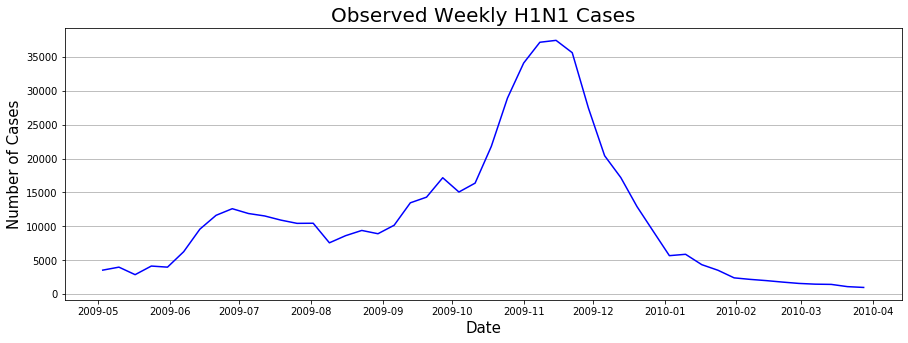

In [294]:
#Code here is used to plot Total Observed Weekly H1N1 Cases:

#group trimmed flu data by EDATE
who_total = trimmed_flu_data.groupby(["EDATE"])

#grab sum
who_vol = who_total["H1N1_Cases"].sum()

#reset index
who_vol.sort_index(inplace = True)

#plot data
plt.figure(figsize = (15,5))
main_plot = plt.plot( who_vol, color = "blue", label = "Cases")
plt.tick_params(axis = 'both', labelsize = 10)

ax = plt.axes()

#set titles and axis labels
plt.title("Observed Weekly H1N1 Cases", fontsize = 20)
plt.ylabel("Number of Cases", fontsize = 15)
plt.xlabel("Date", fontsize = 15)
plt.grid(axis = 'y')
plt.show()


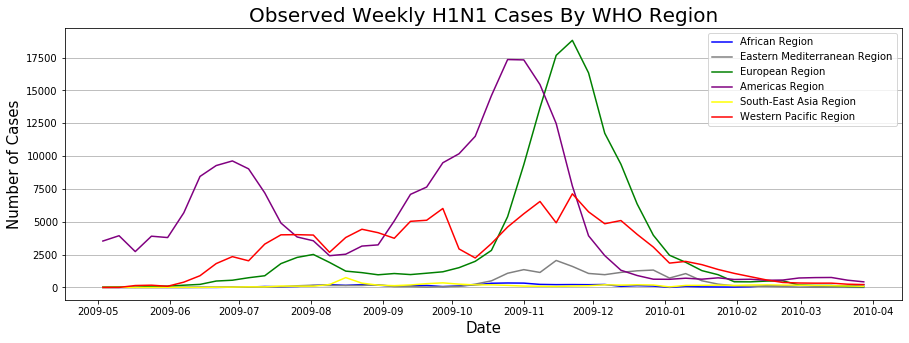

In [295]:
#Code here is used to plot Total Observed Weekly H1N1 Cases BY REGION:

#create filtered dataframes
african = trimmed_flu_data.loc[trimmed_flu_data["WHOREGION"] == 'African Region of WHO']
eastern = trimmed_flu_data.loc[trimmed_flu_data["WHOREGION"] == 'Eastern Mediterranean Region of WHO']
european = trimmed_flu_data.loc[trimmed_flu_data["WHOREGION"] == 'European Region of WHO']
americas = trimmed_flu_data.loc[trimmed_flu_data["WHOREGION"] == 'Region of the Americas of WHO']
southeast = trimmed_flu_data.loc[trimmed_flu_data["WHOREGION"] == 'South-East Asia Region of WHO']
western_pacific = trimmed_flu_data.loc[trimmed_flu_data["WHOREGION"] == 'Western Pacific Region of WHO']

#group by EDATE
african_grouped = african.groupby(['EDATE'])
eastern_grouped = eastern.groupby(['EDATE'])
european_grouped = european.groupby(['EDATE'])
americas_grouped = americas.groupby(['EDATE'])
southeast_grouped = southeast.groupby(['EDATE'])
western_pacific_grouped = western_pacific.groupby(['EDATE'])

#grab summed cases
african_vol = african_grouped["H1N1_Cases"].sum()
eastern_vol = eastern_grouped["H1N1_Cases"].sum()
european_vol = european_grouped["H1N1_Cases"].sum()
americas_vol = americas_grouped["H1N1_Cases"].sum()
southeast_vol = southeast_grouped["H1N1_Cases"].sum()
western_pacific_vol = western_pacific_grouped["H1N1_Cases"].sum()

#plot lines
plt.figure(figsize = (15,5))
african_plot = plt.plot(african_vol, color="blue", label = "African Region")
eastern_plot, = plt.plot(eastern_vol , color="gray", label = "Eastern Mediterranean Region")
european_plot, = plt.plot(european_vol , color="green", label = "European Region")
americas_plot, = plt.plot(americas_vol , color="purple", label = "Americas Region")
southeast_plot, = plt.plot(southeast_vol , color="yellow", label = "South-East Asia Region")
western_pacific_plot, = plt.plot(western_pacific_vol , color="red", label = "Western Pacific Region")

#set titles and axis labels
plt.title("Observed Weekly H1N1 Cases By WHO Region", fontsize = 20)
plt.ylabel("Number of Cases", fontsize = 15)
plt.xlabel("Date", fontsize = 15)
plt.legend(loc = "best")
plt.grid(axis = 'y')
plt.show()



# Flight Data Portion

In [296]:
#Code here is preparing the flight data to merge with USA flu data

# Drop the last few rows which have null values
flight_data_df = flight_data_df.dropna(how='any')

#remove TOTAL function from df
flight_data_df = flight_data_df[flight_data_df['Month'] != 'TOTAL']

#convert Year and Month to String datatype
flight_data_df['Year'] = flight_data_df['Year'].astype(str)
# flight_data_df['Month'] = flight_data_df['Month'].astype(str)
# flight_data_df['DOMESTIC'] = flight_data_df['DOMESTIC'].astype(str)
# flight_data_df['INTERNATIONAL'] = flight_data_df['INTERNATIONAL'].astype(str)
# flight_data_df['TOTAL'] = flight_data_df['TOTAL'].astype(str)
# flight_data_df['Date'] = flight_data_df['Date'].astype(str)

flight_data_df.dtypes

#grab column names
columns = flight_data_df.columns

#convert columns to float values
for column in columns:
    flight_data_df[column] = flight_data_df[column].str.replace(",","").astype(float)

#convert year and month to int
flight_data_df['Year'] = flight_data_df['Year'].astype(int)
flight_data_df['Month'] = flight_data_df['Month'].astype(int)


In [297]:
#View flight data df
flight_data_df 

,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL
0,2002,10,815489.0,92565.0,908054.0
1,2002,11,766775.0,91342.0,858117.0
2,2002,12,782175.0,96881.0,879056.0
4,2003,1,785651.0,98053.0,883704.0
5,2003,2,690750.0,85965.0,776715.0
...,...,...,...,...,...
219,2019,8,769346.0,147077.0,916423.0
220,2019,9,703929.0,123258.0,827187.0
221,2019,10,740139.0,126268.0,866407.0
222,2019,11,694283.0,119996.0,814279.0


In [298]:
#view flight data types
flight_data_df.dtypes

Year               int32
Month              int32
DOMESTIC         float64
INTERNATIONAL    float64
TOTAL            float64
dtype: object

In [299]:
#create a list of Dates and populate it
Date = []
for y, m in zip(flight_data_df.Year, flight_data_df.Month):
    Date.append(date(y, m, 1))

#Add Date column based on list above
flight_data_df['Date'] = Date

#create average flight dataframe
avg_flight_df = flight_data_df.groupby(['Month']).mean()

#drop Year columns in average flight df
del avg_flight_df['Year']

#preview flight df
avg_flight_df.head()



,DOMESTIC,INTERNATIONAL,TOTAL
Month,,,
1,709095.588235,114327.058824,823422.647059
2,654495.647059,103400.117647,757895.764706
3,756308.000000,118632.764706,874940.764706
4,735376.470588,115093.529412,850470.000000
5,760489.588235,116253.823529,876743.411765


In [300]:
#create USA specific df
usa_df = trimmed_flu_data.loc[trimmed_flu_data["Country"] == 'United States of America']

#group by Year and Month
usa_df = usa_df.groupby(['Year', 'Month']).sum()

#remove columns
del usa_df['Week']

#merge usa flight and flu data
merged_df = pd.merge(flight_data_df, usa_df, on = ['Year', 'Month'], how="inner")

#do a second merge to add average flight df
merged_df = pd.merge(merged_df, avg_flight_df, on = 'Month', how = "inner", suffixes = ("", "_AVG"))


merged_df.sort_values(by = ['Date'], inplace = True, ascending = True, axis = 0)

merged_df

,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL,Date,H1N1_Cases,DOMESTIC_AVG,INTERNATIONAL_AVG,TOTAL_AVG
0,2009,5,749196.0,99434.0,848630.0,2009-05-01,11309.0,760489.588235,116253.823529,876743.411765
1,2009,6,760357.0,106627.0,866984.0,2009-06-01,15129.0,764665.882353,119949.294118,884615.176471
2,2009,7,794188.0,115443.0,909631.0,2009-07-01,8922.0,793565.470588,128120.823529,921686.294118
3,2009,8,781510.0,113768.0,895278.0,2009-08-01,7425.0,790749.882353,125386.764706,916136.647059
4,2009,9,709954.0,97400.0,807354.0,2009-09-01,9653.0,722832.411765,108249.235294,831081.647059
5,2009,10,726799.0,98788.0,825587.0,2009-10-01,28330.0,754037.333333,108728.944444,862766.277778
6,2009,11,694945.0,97589.0,792534.0,2009-11-01,22571.0,714020.277778,105267.888889,819288.166667
7,2009,12,705101.0,106367.0,811468.0,2009-12-01,2338.0,725590.333333,115097.222222,840687.555556
8,2010,1,695109.0,108804.0,803913.0,2010-01-01,1397.0,709095.588235,114327.058824,823422.647059
9,2010,2,623211.0,96264.0,719475.0,2010-02-01,1104.0,654495.647059,103400.117647,757895.764706


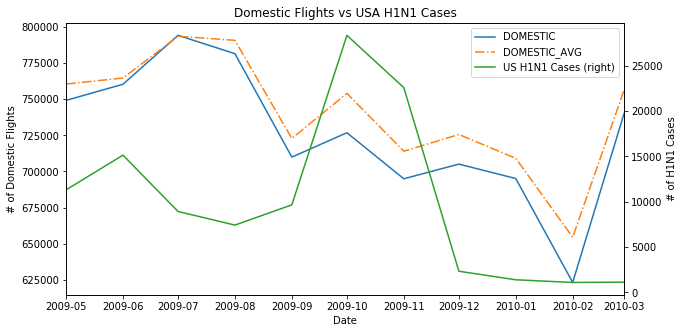

In [319]:
#plotting the USA data

plt.figure(figsize = (10,5))
ax = plt.gca()


merged_df.plot.line(x = 'Date', y='DOMESTIC', ax=ax)
merged_df.plot.line(x = 'Date', y = 'DOMESTIC_AVG', ax=ax, linestyle = '-.')

#create a second axis that contains the H1N1 Case data
ax2 = merged_df.plot.line(x = 'Date', y='H1N1_Cases', ax=ax, secondary_y = True, label = 'US H1N1 Cases')

#set titles and labels
plt.title("Domestic Flights vs USA H1N1 Cases")
ax.set_ylabel('# of Domestic Flights')
ax2.set_ylabel('# of H1N1 Cases')

#show chart
plt.show()

The r-squared is: 0.1928656967672986


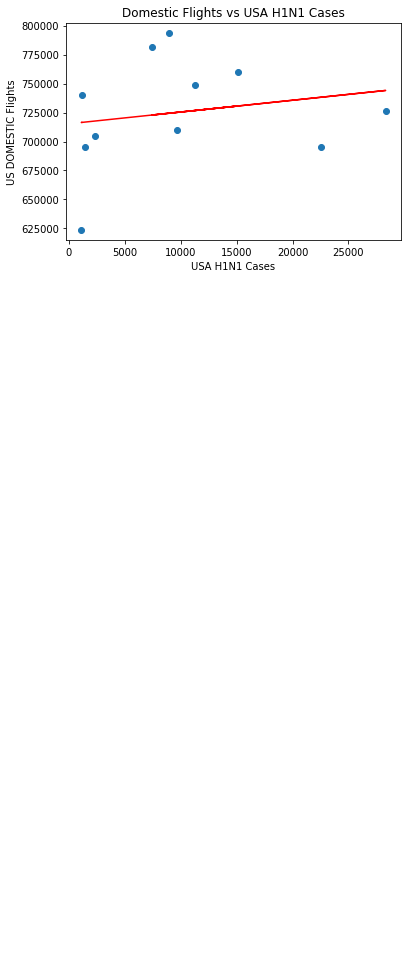

In [302]:
#run scatter plot and calculate r square
x_values = merged_df['H1N1_Cases']
y_values = merged_df['DOMESTIC']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('USA H1N1 Cases')
plt.ylabel('US DOMESTIC Flights')
plt.title("Domestic Flights vs USA H1N1 Cases")
print(f"The r-squared is: {rvalue}")
plt.show()

In [326]:
#create International specific df
intl_df = trimmed_flu_data.loc[trimmed_flu_data["Country"] != 'United States of America']

#group by Year and Month
intl_df = intl_df.groupby(['Year', 'Month']).sum()

#remove columns
del intl_df['Week']

#merge International flight and flu data
intl_merged_df = pd.merge(flight_data_df, intl_df, on = ['Year', 'Month'], how="inner")

#do a second merge to add average flight df
intl_merged_df = pd.merge(intl_merged_df, avg_flight_df, on = 'Month', how = "inner", suffixes = ("", "_AVG"))


intl_merged_df.sort_values(by = ['Date'], inplace = True, ascending = True, axis = 0)

intl_merged_df

,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL,Date,H1N1_Cases,DOMESTIC_AVG,INTERNATIONAL_AVG,TOTAL_AVG
0,2009,5,749196.0,99434.0,848630.0,2009-05-01,7282.0,760489.588235,116253.823529,876743.411765
1,2009,6,760357.0,106627.0,866984.0,2009-06-01,24984.0,764665.882353,119949.294118,884615.176471
2,2009,7,794188.0,115443.0,909631.0,2009-07-01,35897.0,793565.470588,128120.823529,921686.294118
3,2009,8,781510.0,113768.0,895278.0,2009-08-01,37581.0,790749.882353,125386.764706,916136.647059
4,2009,9,709954.0,97400.0,807354.0,2009-09-01,45482.0,722832.411765,108249.235294,831081.647059
5,2009,10,726799.0,98788.0,825587.0,2009-10-01,53825.0,754037.333333,108728.944444,862766.277778
6,2009,11,694945.0,97589.0,792534.0,2009-11-01,149107.0,714020.277778,105267.888889,819288.166667
7,2009,12,705101.0,106367.0,811468.0,2009-12-01,57493.0,725590.333333,115097.222222,840687.555556
8,2010,1,695109.0,108804.0,803913.0,2010-01-01,20498.0,709095.588235,114327.058824,823422.647059
9,2010,2,623211.0,96264.0,719475.0,2010-02-01,6484.0,654495.647059,103400.117647,757895.764706


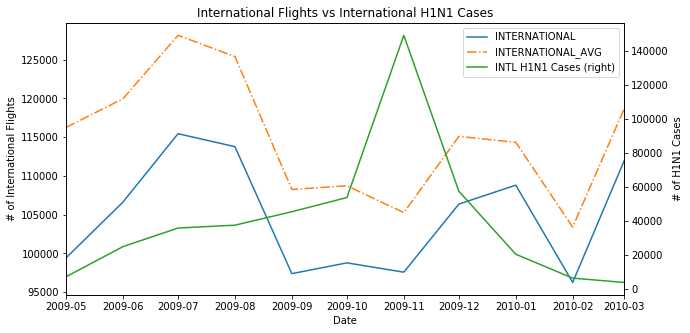

In [329]:
#plotting the International data

plt.figure(figsize = (10,5))
ax = plt.gca()

intl_merged_df.plot.line(x = 'Date', y='INTERNATIONAL', ax=ax)
intl_merged_df.plot.line(x = 'Date', y = 'INTERNATIONAL_AVG', ax=ax, linestyle = '-.')

#create a second axis that contains the H1N1 Case data
ax3 = intl_merged_df.plot.line(x = 'Date', y='H1N1_Cases', ax=ax, secondary_y = True, label = 'INTL H1N1 Cases')

#set titles and labels
plt.title("International Flights vs International H1N1 Cases")
ax.set_ylabel('# of International Flights')
ax3.set_ylabel('# of H1N1 Cases')

#show chart
plt.show()

The r-squared is: -0.10189615898805172


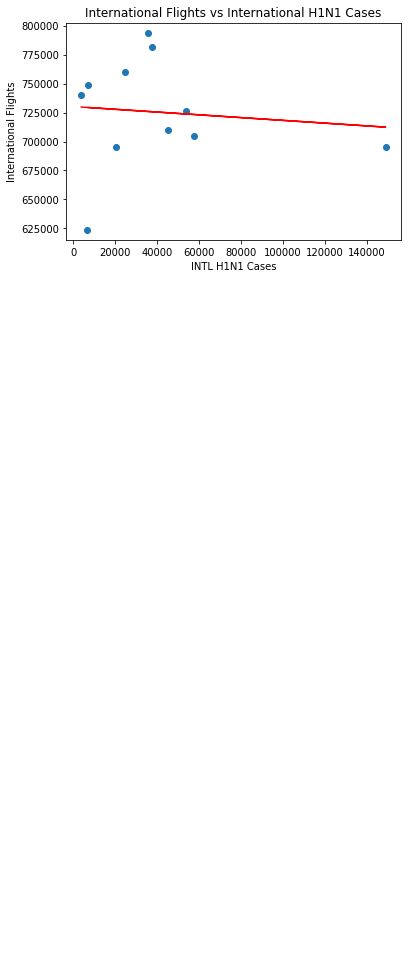

In [332]:
#run scatter plot and calculate r square
x_values = intl_merged_df['H1N1_Cases']
y_values = intl_merged_df['DOMESTIC']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('INTL H1N1 Cases')
plt.ylabel('International Flights')
plt.title("International Flights vs International H1N1 Cases")
print(f"The r-squared is: {rvalue}")
plt.show()

# HeatMap Portion

In [263]:
lat_lng_df = lat_lng_df.rename(columns={"name_long": "Country"})
lat_lng_df = lat_lng_df.replace(to_replace=['United States'],
                value='United States of America')


#create summary dataframe
who_country = flu_data.groupby('Country').sum()
who_summary = pd.DataFrame ({
                "H1N1 Case Count": who_country['H1N1_Cases']
})

who_summary.sort_values(by = ['H1N1 Case Count'], inplace = True, ascending = False, axis = 0)

who_summary = who_summary.reset_index()

max_cases = who_summary["H1N1 Case Count"].max()

h1n1_countries_latlng = pd.merge(who_summary, lat_lng_df, on = 'Country')

h1n1_countries_latlng.head()

who_summary




,Country,H1N1 Case Count
0,United States of America,110332.0
1,China,73117.0
2,Mexico,72573.0
3,Canada,39770.0
4,Japan,32760.0
...,...,...
166,Saudi Arabia,0.0
167,Chad,0.0
168,Seychelles,0.0
169,Sierra Leone,0.0


In [264]:
# Access maps with unique API key
gmaps.configure(api_key=g_key)

locations = h1n1_countries_latlng[["Latitude", "Longitude"]]

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=h1n1_countries_latlng['H1N1 Case Count'], 
                                 dissipating=False, max_intensity=max_cases)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))